In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score, fbeta_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_hastie_10_2
import warnings
import gc
import time
from contextlib import contextmanager
from IPython.display import clear_output
warnings.simplefilter(action='ignore', category=FutureWarning)

# Modélisation : Feature engineering

In [3]:
# @contextmanager
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def imputation(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    for cols in df.columns:
        if cols in categorical_columns:
            df[cols] = imp_cat.fit_transform(df[cols].values.reshape(-1, 1))
        else:
            df[cols] = imp_num.fit_transform(df[cols].values.reshape(-1, 1))
    print("nan : ",df.isna().sum().sum())
    return df

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df = imputation(df)
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    print(df.isna().sum().sum())
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = False):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb = imputation(bb)
    bureau = imputation(bureau)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    print(bureau_agg.isna().sum().sum())
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = False):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev = imputation(prev)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= nan_as_category)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    print(prev_agg.isna().sum().sum())
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = False):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos = imputation(pos)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= nan_as_category)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    print(pos_agg.isna().sum().sum())
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = False):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins = imputation(ins)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= nan_as_category)
    display(ins.head())
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    print(ins_agg.isna().sum().sum())
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = False):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc = imputation(cc)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= nan_as_category)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    print(cc_agg.isna().sum().sum())
    return cc_agg

In [4]:
# num_rows = None
# df = application_train_test(num_rows)
# bureau = bureau_and_balance(num_rows)
# print("Bureau df shape:", bureau.shape)
# df = df.join(bureau, how='left', on='SK_ID_CURR')
# del bureau
# prev = previous_applications(num_rows)
# print("Previous applications df shape:", prev.shape)
# df = df.join(prev, how='left', on='SK_ID_CURR')
# del prev
# pos = pos_cash(num_rows)
# print("Pos-cash balance df shape:", pos.shape)
# df = df.join(pos, how='left', on='SK_ID_CURR')
# del pos
# ins = installments_payments(num_rows)
# print("Installments payments df shape:", ins.shape)
# df = df.join(ins, how='left', on='SK_ID_CURR')
# del ins
# cc = credit_card_balance(num_rows)
# print("Credit card balance df shape:", cc.shape)
# df = df.join(cc, how='left', on='SK_ID_CURR')
# del cc

In [5]:
train = pd.read_csv("data//application_train.csv")

In [6]:
test = pd.read_csv("data//application_test.csv")

In [7]:
bureau = pd.read_csv("data//bureau.csv")

In [ ]:
bb = pd.read_csv("data//bureau_balance.csv")

In [6]:
pos = pd.read_csv("data//POS_CASH_balance.csv")

In [7]:
ccb = pd.read_csv("data//credit_card_balance.csv")

In [8]:
prev = pd.read_csv("data//previous_application.csv")

In [9]:
ins = pd.read_csv("data//installments_payments.csv")

# Fonctions

In [4]:
def plot_classification_report(y_test, y_pred, y_pred_prob, beta = 2):
    conf_mat = confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    df_cm = pd.DataFrame(conf_mat, index = [0,1], columns = [i for i in "01"])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
    fig, ax = plt.subplots(1, 2, figsize = (15,7))
    sns.heatmap(df_cm, annot=True, ax = ax[0], cmap="Blues", fmt="d", cbar = False)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    ax[0].set_title("Confusion Matrix")
    ax[1].plot(fpr,tpr)
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    roc = round(100*roc_auc_score(y_test, y_pred),2)
    ax[1].text(1,0,"AUC : " + str(roc) + "%", fontsize=14, verticalalignment='bottom', horizontalalignment = 'right')
    plt.show()
    print("accuracy : ", round(100*accuracy_score(y_test, y_pred),2), "%")
    print("precision : ", round(100*tp/(tp+fp),2), "%")
    print("recall : ", round(100*tp/(tp+fn),2), "%")
    print("f"+str(beta) + " : ", round(100*fbeta_score(y_test,y_pred, beta = beta), 2))
    print("log_loss : ", round(log_loss(y_test,y_pred),2))
    print("AUC : ", roc, "%")

In [1]:
n_sample = 500
df = pd.read_csv("df.csv")
df = df[df.TARGET.isna()]
df = df.sample(n = n_sample, random_state = 42)
df = df.replace([np.inf, -np.inf], np.nan)

In [ ]:
df.TARGET.value_counts()

# Regression Logistique

In [ ]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]) 
categ_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mode")), ("onehot", OneHotEncoder(handle_unknown="ignore")())]) 
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features),])
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
clf.fit(X_train, y_train) 
print("model score: %.3f" % clf.score(X_test, y_test))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

metric = "f1"
# preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), selector(dtype_exclude="category"))])
preprocessor = StandardScaler()
pipe = Pipeline([('transformer', preprocessor), ('estimator', LogisticRegression(random_state=0, class_weight = 'balanced'))])
parameters = {'estimator__class_weight' : ('balanced', None)}
search_rl = GridSearchCV(pipe, parameters, scoring = metric, return_train_score = True)
search_rl.fit(X_train, y_train)
print(search_rl.best_params_)
print(search_rl.best_score_)
y_pred_rl = search_rl.predict(X_test)
y_pred_prob_rl = search_rl.predict_proba(X_test)

{'estimator__class_weight': 'balanced'}
0.27306570601063157


In [16]:
# afficher le score d'entraînement

In [19]:
print(search_rl.cv_results_["mean_test_score"])

[0.27306571 0.07393083]


In [22]:
print(search_rl.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__class_weight', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [23]:
search_rl.cv_results_["mean_train_score"]

array([0.29600248, 0.09586134])

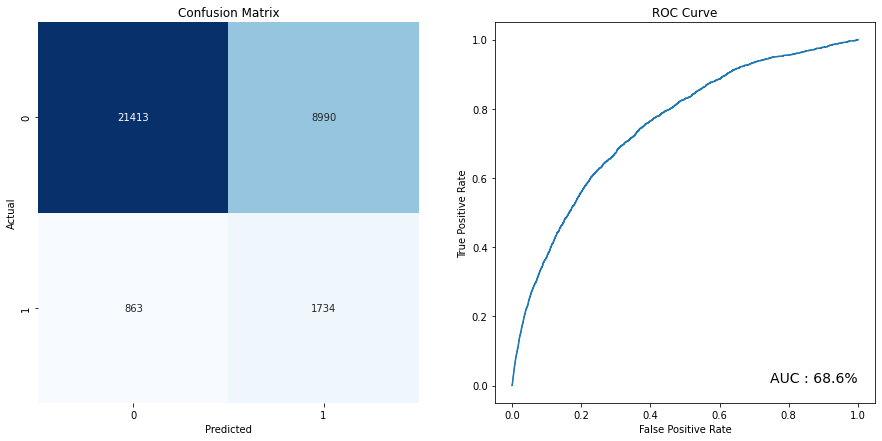

accuracy :  70.14 %
precision :  16.17 %
recall :  66.77 %
f2 :  41.07
log_loss :  10.31
AUC :  68.6 %


In [30]:
plot_classification_report(y_test, y_pred_rl, y_pred_prob_rl)
# tester le fbeta : 

In [10]:
# # get importance
# importance = pipe["estimator"].coef_[0]
# importance_sorted = np.sort(importance)
# importance_best = importance_sorted[:15]
# # summarize feature importance
# for i,v in enumerate(importance_best):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance_best))], abs(importance_best))
# plt.show()

# Gradient Boosting

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
pipe = Pipeline([('transformer', StandardScaler()), ('estimator', GB)])
pipe.fit(X_train, y_train)
y_pred_gb = pipe.predict(X_test)
y_pred_prob_gb = pipe.predict_proba(X_test)

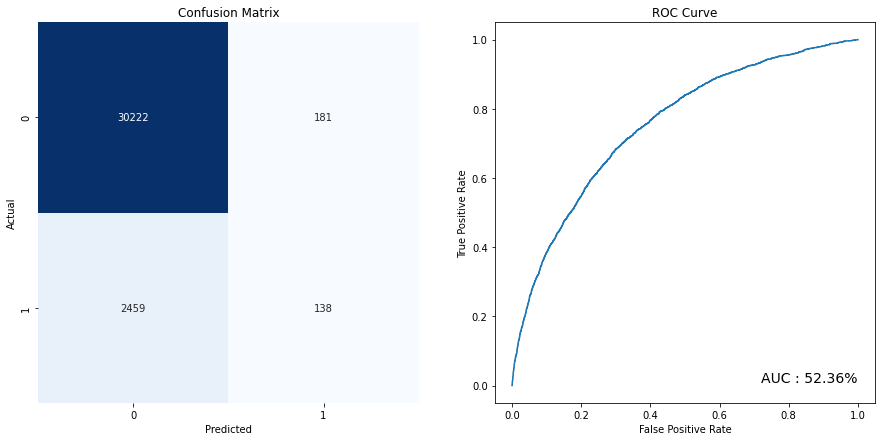

accuracy :  92.0 %
precision :  43.26 %
recall :  5.31 %
log_loss :  2.76
AUC :  52.36 %


In [141]:
plot_classification_report(y_test, y_pred_gb, y_pred_prob_gb)

# LightGBM

In [153]:
feature_importance_df = pd.DataFrame()
feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1,)

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

y_pred_lgbm = clf.predict(X_test, num_iteration=clf.best_iteration_)

y_pred_prob_lgbm = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)

print('AUC : %.6f' % (roc_auc_score(y_test, y_pred_lgbm)))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.836335	training's binary_logloss: 0.223406	valid_1's auc: 0.766377	valid_1's binary_logloss: 0.23977
[400]	training's auc: 0.871348	training's binary_logloss: 0.206962	valid_1's auc: 0.772946	valid_1's binary_logloss: 0.237262
[600]	training's auc: 0.894542	training's binary_logloss: 0.195536	valid_1's auc: 0.774617	valid_1's binary_logloss: 0.236727
[800]	training's auc: 0.913818	training's binary_logloss: 0.185527	valid_1's auc: 0.775231	valid_1's binary_logloss: 0.236574
[1000]	training's auc: 0.92916	training's binary_logloss: 0.176481	valid_1's auc: 0.775144	valid_1's binary_logloss: 0.236675
AUC : 0.521107


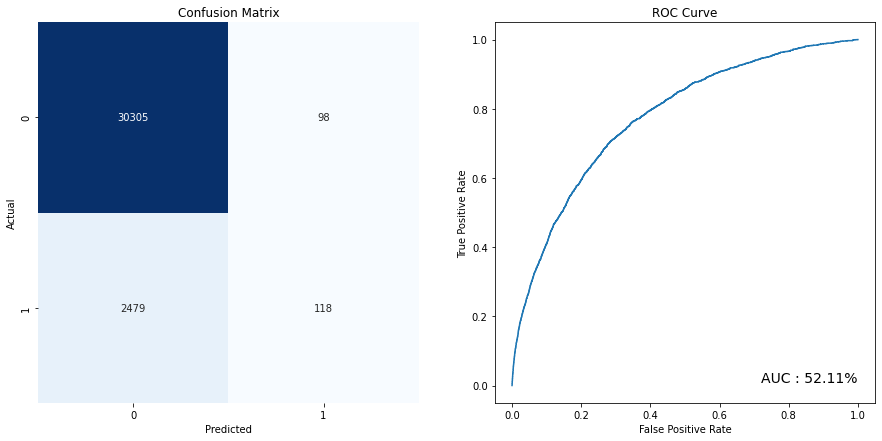

accuracy :  92.19 %
precision :  54.63 %
recall :  4.54 %
log_loss :  2.7
AUC :  52.11 %


In [154]:
plot_classification_report(y_test, y_pred_lgbm, y_pred_prob_lgbm)